# IMPORT LIBRARIES

In [2]:
# ======================
# LIBRARY IMPORTS
# ======================
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk import word_tokenize, ngrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from typing import Optional, Dict, List, Tuple
import string
import re
from sklearn.model_selection import train_test_split
import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoModelForCausalLM
)
import traceback
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.utils.checkpoint
#import evaluate
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
import wandb
from peft import LoraConfig, get_peft_model
import random
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["TORCH_USE_REENTRANT"] = "0"

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
import numpy as np
print(np.__version__)

1.26.4


# DEFINING FUNCTIONS

In [4]:
# ======================
# DATA & LOGIN FUNCTIONS
# ======================

def wandb_login():
    """Authenticate with Weights & Biases for experiment tracking.

    Uses a predefined API key to log into wandb. If login fails,
    prints error message but continues execution.
    """
    try:
        wandb.login(key="your_api_key") #enter your wandb api key here
        print("Successfully logged into Weights & Biases")
    except Exception as e:
        print(f"Warning: Failed to login to wandb: {e}")

def load_financial_phrasebank(source: str) -> pd.DataFrame:
    """Load Financial PhraseBank dataset from local file or Hugging Face.

    Args:
        source: Path to local CSV file or "huggingface" to load from HF

    Returns:
        Loaded DataFrame with financial sentences and labels

    Raises:
        FileNotFoundError: If local file not found
        ConnectionError: If HF dataset cannot be loaded
    """
    try:
        if source.lower() == "huggingface":
            dataset = load_dataset("takala/financial_phrasebank", "sentences_50agree")
            df = dataset["train"].to_pandas()
            print("Successfully loaded dataset from Hugging Face")
        else:
            df = pd.read_csv(source, index_col=0)
            print(f"Successfully loaded dataset from local file: {source}")

        return df

    except Exception as e:
        print(f"Failed to load dataset: {e}")
        return None


In [5]:
def quick_eda(df: pd.DataFrame) -> None:
    """Perform exploratory data analysis on the dataset.

    Displays:
    - First 5 rows
    - DataFrame shape
    - Column info and data types
    - Statistical summary

    Args:
        df: Input DataFrame to analyze
    """
    try:
        print("="*50)
        print("1. FIRST 5 ROWS".center(50))
        print("="*50)
        display(df.head())

        print("\n" + "="*50)
        print("2. DATAFRAME SHAPE".center(50))
        print("="*50)
        print(f"Rows: {df.shape[0]:,}, Columns: {df.shape[1]}")

        print("\n" + "="*50)
        print("3. DATAFRAME INFO".center(50))
        print("="*50)
        df.info()

        print("\n" + "="*50)
        print("4. STATISTICAL SUMMARY".center(50))
        print("="*50)
        display(df.describe(include='all'))

    except Exception as e:
        print(f"EDA Error: {str(e)}")

def handle_duplicates(df: pd.DataFrame, subset=None, keep='first', inplace=False) -> pd.DataFrame:
    """Identify and handle duplicate rows in the dataset.

    Args:
        df: Input DataFrame
        subset: Columns to consider for duplicates
        keep: Which duplicates to keep ('first', 'last', False)
        inplace: Modify DataFrame in place

    Returns:
        DataFrame with duplicates removed (or None if inplace=True)
    """
    try:
        duplicates = df.duplicated(subset=subset, keep=keep)
        duplicate_count = duplicates.sum()

        print(f"Found {duplicate_count} duplicate row(s)")

        if duplicate_count > 0:
            if inplace:
                df.drop_duplicates(subset=subset, keep=keep, inplace=True)
                print(f"Removed {duplicate_count} duplicates (inplace)")
                return None
            else:
                cleaned_df = df.drop_duplicates(subset=subset, keep=keep)
                print(f"Removed {duplicate_count} duplicates")
                return cleaned_df
        return df if not inplace else None

    except Exception as e:
        print(f"Duplicate handling error: {str(e)}")
        return df

def add_sentiment_column(
    df: pd.DataFrame,
    label_col: str = "label",
    output_col: str = "sentiment",
    mapping: dict = {0: "negative", 1: "neutral", 2: "positive"},
    inplace: bool = False
) -> pd.DataFrame:
    """Add descriptive sentiment column based on numerical labels.

    Args:
        df: Input DataFrame
        label_col: Column with numerical labels
        output_col: New column name for sentiment
        mapping: Dictionary mapping numbers to sentiment
        inplace: Modify DataFrame in place

    Returns:
        DataFrame with new sentiment column
    """
    try:
        if not inplace:
            df = df.copy()

        df[output_col] = df[label_col].map(mapping)

        if not inplace:
            return df

    except Exception as e:
        print(f"Error adding sentiment column: {str(e)}")
        return df if not inplace else None

In [6]:
def visualize_text_analysis(
    df: pd.DataFrame,
    text_col: str = "sentence",
    sentiment_col: str = "sentiment",
    figsize: tuple = (15, 10)
) -> None:
    """Generate comprehensive text analysis visualizations.

    Includes:
    - Token count distribution
    - Sentiment distribution
    - Word clouds (overall and by sentiment)
    - Unigram, bigram, and trigram frequency analysis

    Args:
        df: Input DataFrame
        text_col: Column containing text data
        sentiment_col: Column with sentiment labels
        figsize: Figure dimensions
    """
    try:


        # Token Count Analysis
        df['token_count'] = df[text_col].apply(lambda x: len(word_tokenize(str(x))))
        plt.figure(figsize=(figsize[0], figsize[1]//2))
        sns.histplot(df['token_count'], bins=10, kde=True, color='blue')
        plt.title("Token Count Distribution")
        plt.xlabel("Token Count")
        plt.ylabel("Frequency")
        plt.show()

        # Sentiment Distribution
        plt.figure(figsize=(8, 8))
        df[sentiment_col].value_counts().plot.pie(autopct='%1.1f%%')
        plt.title("Sentiment Distribution")
        plt.ylabel("")
        plt.show()

        # Overall Word Cloud
        text = " ".join(df[text_col].astype(str))
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(figsize[0], figsize[1]//2))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("Word Cloud - Full Dataset")
        plt.show()

        # Word Clouds by Sentiment
        sentiments = ["positive", "neutral", "negative"]
        plt.figure(figsize=(figsize[0], figsize[1]//2))
        for i, sentiment in enumerate(sentiments, 1):
            sentiment_text = " ".join(df[df[sentiment_col] == sentiment][text_col])
            wordcloud = WordCloud(width=800, height=400, background_color="white").generate(sentiment_text)
            plt.subplot(1, 3, i)
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"Word Cloud - {sentiment.capitalize()}")
        plt.tight_layout()
        plt.show()

        # Prepare sentences for N-gram analysis
        sentences = df[text_col].astype(str).tolist()

        # Helper function to plot bar charts
        def plot_counts(counter_dict, title, color):
            plt.figure(figsize=(figsize[0]//2, figsize[1]//2))
            items = sorted(counter_dict.items(), key=lambda x: x[1])
            labels, counts = zip(*items)
            plt.barh(labels, counts, color=color)
            plt.title(title)
            plt.xlabel("Frequency")
            plt.tight_layout()
            plt.show()

        # Unigrams
        words = [word.lower() for sentence in sentences for word in word_tokenize(sentence)]
        common_unigrams = dict(Counter(words).most_common(25))
        plot_counts(common_unigrams, "Top 25 Unigrams by Count", "skyblue")

        # Bigrams
        bigrams = [" ".join(bigram) for sentence in sentences for bigram in ngrams(word_tokenize(sentence.lower()), 2)]
        common_bigrams = dict(Counter(bigrams).most_common(25))
        plot_counts(common_bigrams, "Top 25 Bigrams by Count", "lightcoral")

        # Trigrams
        trigrams = [" ".join(trigram) for sentence in sentences for trigram in ngrams(word_tokenize(sentence.lower()), 3)]
        common_trigrams = dict(Counter(trigrams).most_common(25))
        plot_counts(common_trigrams, "Top 25 Trigrams by Count", "mediumseagreen")

    except Exception as e:
        print(f"Visualization error: {str(e)}")


In [7]:
def data_preprocessing(
    df,
    column_name="sentence",
    remove_special_chars=True,
    remove_punctuation=True,
    lowercase=True,
    convert_symbols=True,
    normalize_spaces=True,
    remove_stopwords=True,
    expand_terms=True,
    remove_urls=True,
    lemmatize=True
):
    """
    Applies text preprocessing steps to the specified column in the DataFrame in-place.
    Each step is optional and controlled by boolean flags.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the text data to be processed (modified in-place)
    column_name : str, optional
        Name of the column to process (default: "sentence")
    remove_special_chars : bool, optional
        Whether to remove special characters (default: True)
    remove_punctuation : bool, optional
        Whether to remove selected punctuation (default: True)
    lowercase : bool, optional
        Whether to convert text to lowercase (default: True)
    convert_symbols : bool, optional
        Whether to convert financial symbols to text (default: True)
    normalize_spaces : bool, optional
        Whether to normalize whitespace (default: True)
    remove_stopwords : bool, optional
        Whether to remove stopwords (default: True)
    expand_terms : bool, optional
        Whether to expand financial abbreviations (default: True)
    remove_urls : bool, optional
        Whether to remove URLs (default: True)
    lemmatize : bool, optional
        Whether to lemmatize while preserving financial terms (default: True)

    Returns:
    --------
    DataFrame
        Modified DataFrame with processed text

    Raises:
    -------
    Exception
        If any preprocessing step fails
    """
    try:
        df_processed = df.copy()
        # Define processing functions
        def _remove_special_chars(text):
            unwanted_chars = [
                ")-", ")--", "),", ")", "+¬", "+í", "+ú", "??", "+â", "+ñ+ñ", "+ä+ä",
                "--------------", "----------------------------------------------------------------------",
                "-Á", "+é", "+ä+ñ", "-«", "+®", "-®", "+Â", "+ó", "+à", ";", "--",
                "+ñ", "&", "''", "'", "+Ñ", "`", "(", "¦", "``"
            ]
            pattern = "|".join(map(re.escape, unwanted_chars))
            return re.sub(pattern, " ", str(text))

        def _remove_punctuation(text):
            punct_to_remove = "!?,.;:"
            return str(text).translate(str.maketrans('', '', punct_to_remove))

        def _convert_symbols(text):
            symbol_mapping = {
                "£": "pound",
                "$": "dollar",
                "=": "equals",
                "¼": "quarter",
                "%": "percent"
            }
            pattern = "|".join(map(re.escape, symbol_mapping.keys()))
            return re.sub(pattern, lambda match: symbol_mapping[match.group()], str(text))

        def _normalize_whitespace(text):
            return re.sub(r'\s+', ' ', str(text)).strip()

        def _remove_stopwords(text):
            stop_words = set(stopwords.words("english"))
            keep_words = {"no", "nor", "against", "below", "above", "won", "further",
                         "most", "more", "under", "not", "up"}
            stop_words -= keep_words
            words = word_tokenize(str(text))
            return " ".join(word for word in words if word.lower() not in stop_words)

        def _expand_terms(text):
            financial_mapping = {
                "bn": "billion",
                "ml": "million",
                "mln": "million",
                "bln": "billion",
                "mn": "million",
                "eur": "euro",
                "usd": "dollars",
                "pct": "percent"
            }
            pattern = r'\b(' + '|'.join(map(re.escape, financial_mapping.keys())) + r')\b'
            return re.sub(pattern, lambda match: financial_mapping[match.group()], str(text), flags=re.IGNORECASE)

        def _remove_urls(text):
            return re.sub(r"https?://\S+|www\.\S+", "", str(text))

        # Lemmatization setup
        _lemmatizer = None
        _finance_terms = None

        def _lemmatize_preserving_finance(text):
            nonlocal _lemmatizer, _finance_terms
            if _lemmatizer is None:
                _lemmatizer = WordNetLemmatizer()
                _finance_terms = {
                    "alpha", "alternative minimum tax", "annual report", "annualized", "annualized rate of return",
                    "appreciation", "asset allocation", "asset class", "average maturity", "balanced fund",
                    "bear market", "benchmark", "best-in-class", "beta", "blue chip", "board of trustees",
                    "bond", "bond fund", "breakpoint", "bull market", "capital", "capital gain",
                    "capital gains ex-date", "capital gains long term", "capital gains reinvest nav",
                    "capital gains short term", "capital loss", "capitalization", "cash equivalent",
                    "center for carbon transition", "climate action 100+", "common stock",
                    "contingent deferred sales charge", "corporate bond", "corporate engagement",
                    "corporate social responsibility", "country breakdown", "custodian", "cut-off time",
                    "daily dividend factor", "default", "distribution schedule", "diversification",
                    "dividend", "dividend paid", "dividend reinvest nav", "dividend yield",
                    "dollar cost averaging", "dow jones industrial average", "eps", "equities",
                    "equity fund", "exclusions", "ex-dividend", "ex-dividend date", "exchange privilege",
                    "expense ratio", "federal funds rate", "federal reserve board", "financial materiality",
                    "fixed income fund", "fixed income security", "fund", "green bonds", "green bond principles",
                    "growth investing", "growth stock", "growth-style funds", "impact investing",
                    "investment stewardship", "index", "individual retirement account", "inflation",
                    "interest rate", "interest-rate risk", "investment advisor", "investment company",
                    "investment grade bonds", "investment objective", "junk bond", "large-cap",
                    "letter of intent", "lipper ratings", "liquidity", "loads", "long-term investment strategy",
                    "management fee", "market price", "market risk", "market timing", "maturity",
                    "maturity distribution", "median market cap", "mid-cap", "money market mutual fund",
                    "morningstar ratings", "mutual fund", "nasdaq", "net asset value per share",
                    "number of holdings", "p/b ratio", "paris agreement", "par value", "portfolio",
                    "portfolio allocation", "portfolio holdings", "portfolio manager", "positive tilt",
                    "power purchase agreements", "preferred stock", "premium", "price-to-book",
                    "price-to-earnings ratio", "p/e ratio", "prospectus", "proxy", "public offering price",
                    "quality distribution", "r2", "ratings", "recession", "redemption", "reinvestment option",
                    "relative risk and potential return", "renewable energy certificates", "rights of accumulation",
                    "risk tolerance", "sales charge", "sector", "sector breakdown", "securities",
                    "securities and exchange commission", "share", "share class net assets", "share classes",
                    "sharpe ratio", "short-term investment", "small-cap", "social bonds",
                    "standard & poor's index", "standard deviation", "statement of additional information",
                    "stock", "stockholder", "sustainability accounting standards board", "sustainability bonds",
                    "sustainable development goals", "sustainable investing", "sustainability-linked bonds",
                    "systematic investment plan", "task force on climate-related financial disclosures",
                    "tax-exempt income", "thematic", "time horizon", "top 10 holdings",
                    "top 10 long and short positions", "top five contributors", "top five detractors",
                    "top five holdings", "top five industries", "total return", "tracking error",
                    "transfer agent", "treasury bill", "treasury bond", "treasury note", "treasury security",
                    "trustee", "turnover ratio", "united nations-convened net-zero asset owner alliance",
                    "united nations global compact", "united nations-supported principles for responsible investment",
                    "valuation", "value investing", "value stock", "value-style funds", "volatility",
                    "wtd. avg. market cap", "weighted average maturity", "ytd total return", "ytd",
                    "ytd return", "yield", "yield to maturity", "yield to maturity distribution",
                    "12b-1 fee", "30-day sec yield", "52 week high", "52 week low"
                }
            words = str(text).split()
            return " ".join(word if word in _finance_terms else _lemmatizer.lemmatize(word) for word in words)

        # Apply processing steps in specified order
        if remove_special_chars:
            df_processed[column_name] = df_processed[column_name].apply(_remove_special_chars)

        if remove_punctuation:
            df_processed[column_name] = df_processed[column_name].apply(_remove_punctuation)

        if lowercase:
            df_processed[column_name] = df_processed[column_name].str.lower()

        if convert_symbols:
            df_processed[column_name] = df_processed[column_name].apply(_convert_symbols)

        if normalize_spaces:
            df_processed[column_name] = df_processed[column_name].apply(_normalize_whitespace)

        if remove_stopwords:
            df_processed[column_name] = df_processed[column_name].apply(_remove_stopwords)

        if expand_terms:
            df_processed[column_name] = df_processed[column_name].apply(_expand_terms)

        if remove_urls:
            df_processed[column_name] = df_processed[column_name].apply(_remove_urls)

        if lemmatize:
            df_processed[column_name] = df_processed[column_name].apply(_lemmatize_preserving_finance)

        return df_processed

    except Exception as e:
        print(f"Preprocessing error: {str(e)}")
        raise

In [8]:
# ======================
# DATA STPLITTING FUNCITON
# ======================

def stratified_split_data(
    df: pd.DataFrame,
    sentiment_col: str = 'sentiment',
    train_size: float = 0.7,
    val_test_ratio: float = 0.5,
    random_state: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Create stratified train/val/test splits.

    Args:
        df: Input DataFrame
        sentiment_col: Column for stratification
        train_size: Proportion for training set
        val_test_ratio: Ratio of val to test in remaining data
        random_state: Random seed

    Returns:
        Tuple of (train_df, val_df, test_df)
    """
    try:
        # First split: train vs temp (val+test)
        train_df, temp_df = train_test_split(
            df,
            test_size=1-train_size,
            stratify=df[sentiment_col],
            random_state=random_state
        )

        # Second split: val vs test
        val_df, test_df = train_test_split(
            temp_df,
            test_size=val_test_ratio,
            stratify=temp_df[sentiment_col],
            random_state=random_state
        )

        print(f"Train: {train_df.shape[0]:,} samples ({train_size*100:.0f}%)")
        print(f"Validation: {val_df.shape[0]:,} samples ({(1-train_size)*val_test_ratio*100:.0f}%)")
        print(f"Test: {test_df.shape[0]:,} samples ({(1-train_size)*(1-val_test_ratio)*100:.0f}%)")

        return train_df, val_df, test_df

    except Exception as e:
        print(f"Split error: {str(e)}")
        return None, None, None

In [9]:
def optimize_memory_usage(model=None):
    """
    Optimizes memory usage by clearing CUDA cache, configuring checkpointing,
    and optionally disabling model cache.

    This function performs the following operations:
    1. Empties the CUDA cache to free up unused memory
    2. Calls IPC collect to handle inter-process communication memory
    3. Configures torch's checkpoint to use non-reentrant mode
    4. Optionally disables the model's cache if a model is provided

    Args:
        model (optional): A PyTorch model whose cache should be disabled.
                         If None, only CUDA and checkpoint operations are performed.

    Returns:
        None
    """
    # Clear CUDA memory
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    # Configure checkpointing
    torch.utils.checkpoint.use_reentrant = False

    # Optionally disable model caching
    if model is not None:
        model.config.use_cache = False

In [10]:
def get_device(device_name: Optional[str] = None) -> torch.device:
    """Get appropriate torch device (CUDA/CPU).

    Args:
        device_name: Preferred device ('cuda', 'cpu', or None)

    Returns:
        torch.device object
    """
    try:
        if device_name is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            device = torch.device(device_name)

        print(f"Using device: {device}")
        if device.type == 'cuda':
            print(f"GPU: {torch.cuda.get_device_name(0)}")

        return device
    except Exception as e:
        print(f"Device error: {str(e)}")
        return None

# DATA READING & PREPROCESSING

In [11]:
print("\n=== LOADING DATA ===")
df = load_financial_phrasebank("/content/FinancialPhraseBankDataset.csv")
# df = load_financial_phrasebank("huggingface")  # Alternative data reading


=== LOADING DATA ===
Successfully loaded dataset from local file: /content/FinancialPhraseBankDataset.csv


In [12]:
# print("\n=== QUICK EXPLORATORY DATA ANALYSIS ===")
quick_eda(df)


                 1. FIRST 5 ROWS                  


,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2



                2. DATAFRAME SHAPE                
Rows: 4,846, Columns: 2

                3. DATAFRAME INFO                 
<class 'pandas.core.frame.DataFrame'>
Index: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  4846 non-null   object
 1   label     4846 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 113.6+ KB

              4. STATISTICAL SUMMARY              


,sentence,label
count,4846,4846.000000
unique,4838,NaN
top,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...,NaN
freq,2,NaN
mean,NaN,1.156624
std,NaN,0.617616
min,NaN,0.000000
25%,NaN,1.000000
50%,NaN,1.000000
75%,NaN,2.000000


In [13]:
df = handle_duplicates(df, inplace=False)
df = add_sentiment_column(df, inplace=False)

Found 6 duplicate row(s)
Removed 6 duplicates



=== DATA VISUALIZATION ON RAW DATASET  ===


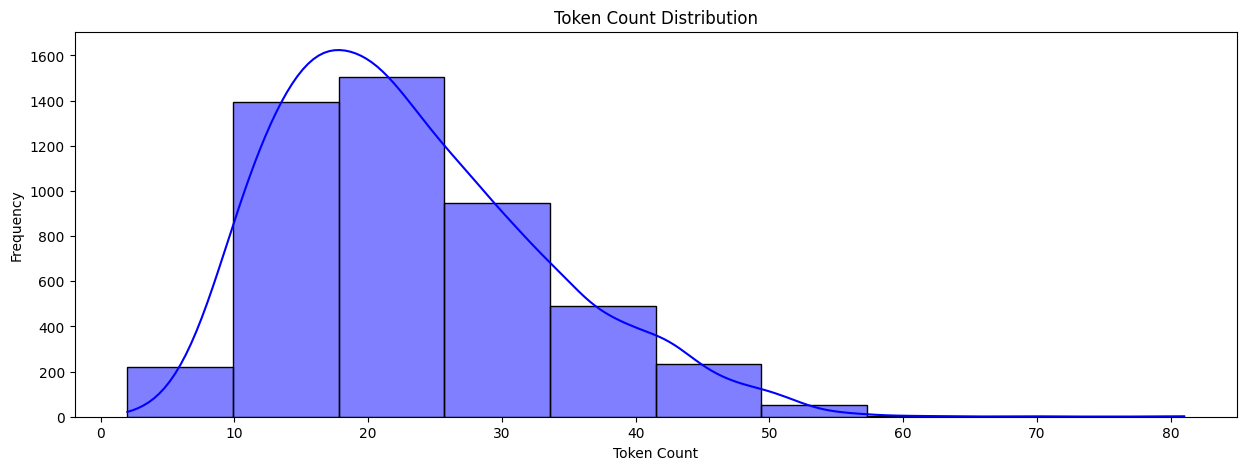

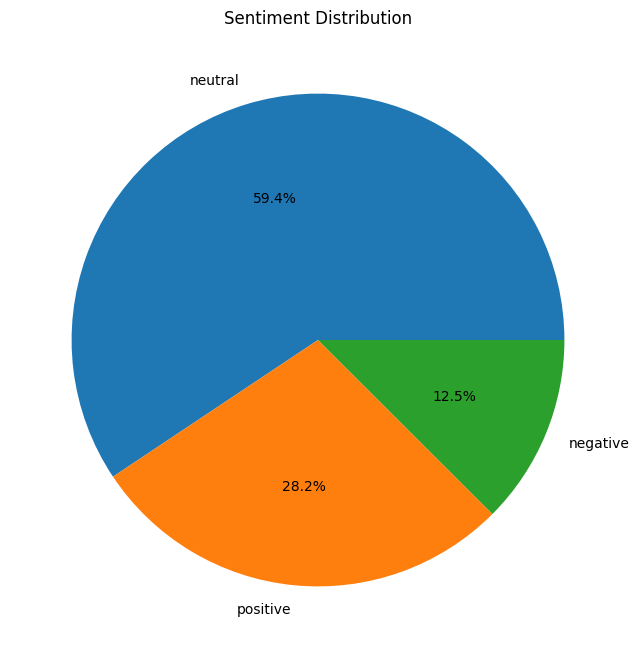

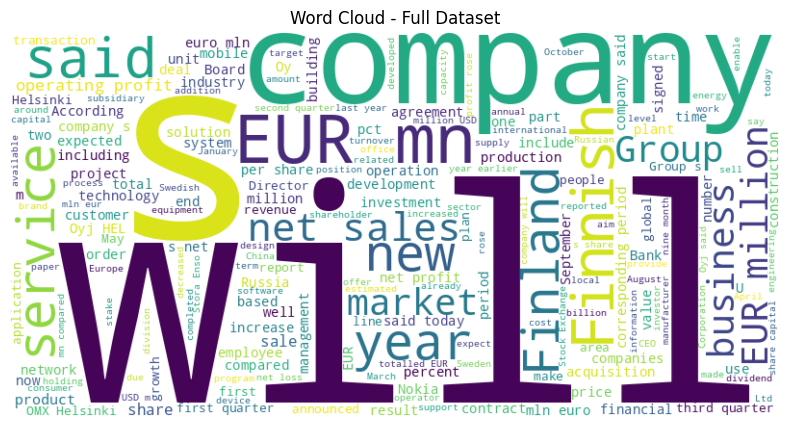

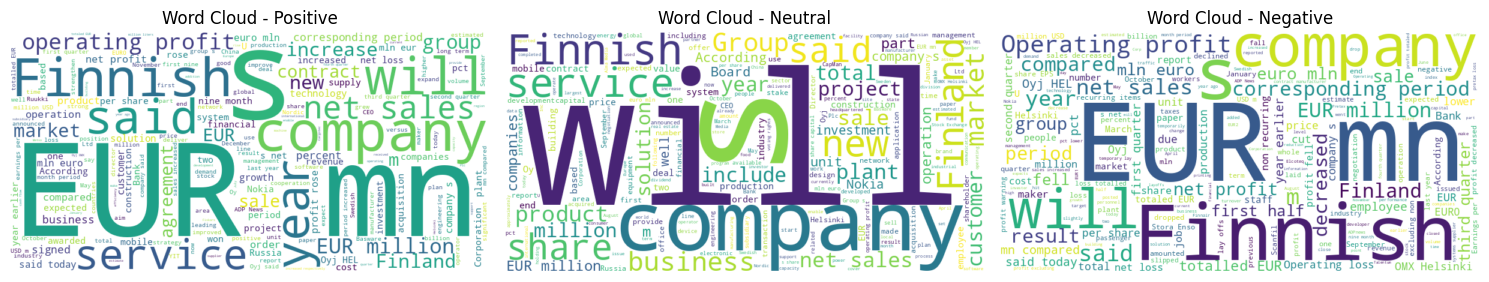

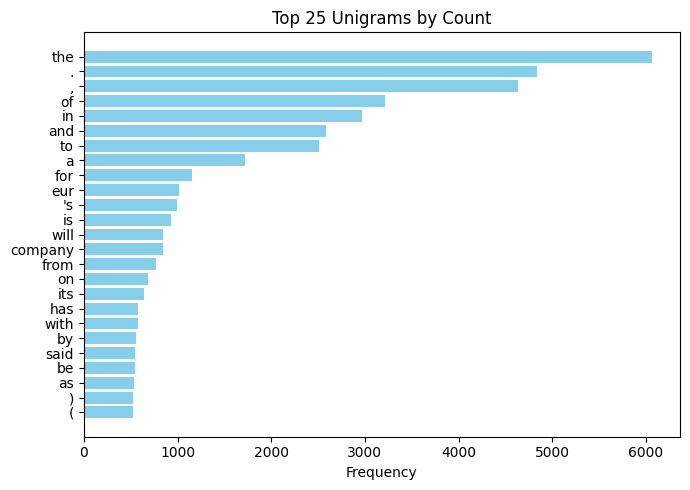

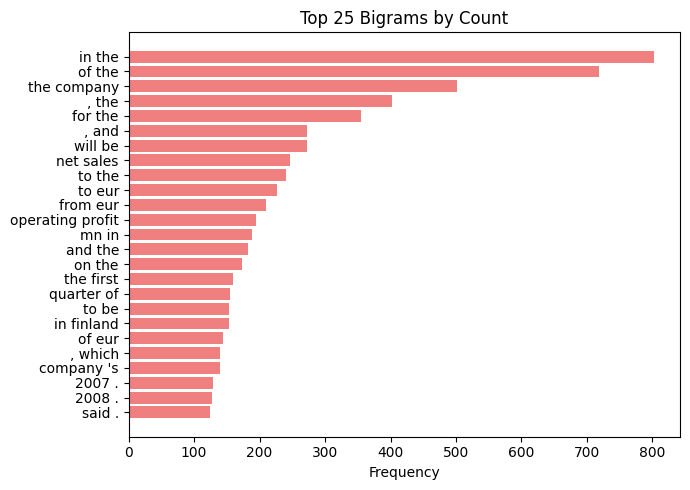

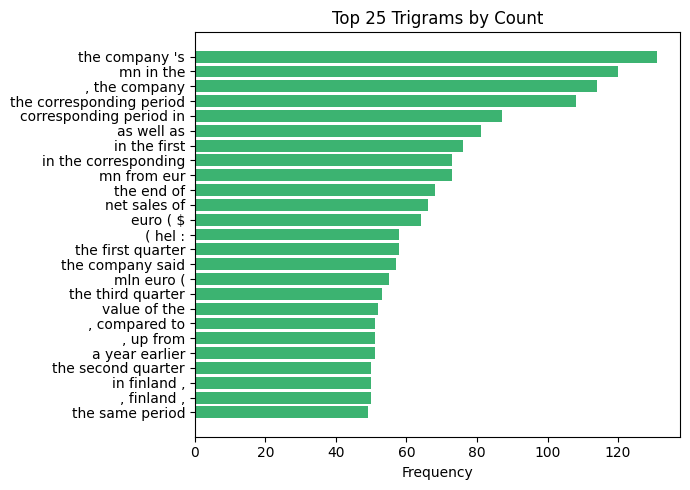

In [108]:
print("\n=== DATA VISUALIZATION ON RAW DATASET  ===")
visualize_text_analysis(df)



=== DATA VISUALIZATION ON PROCESSED DATASET  ===


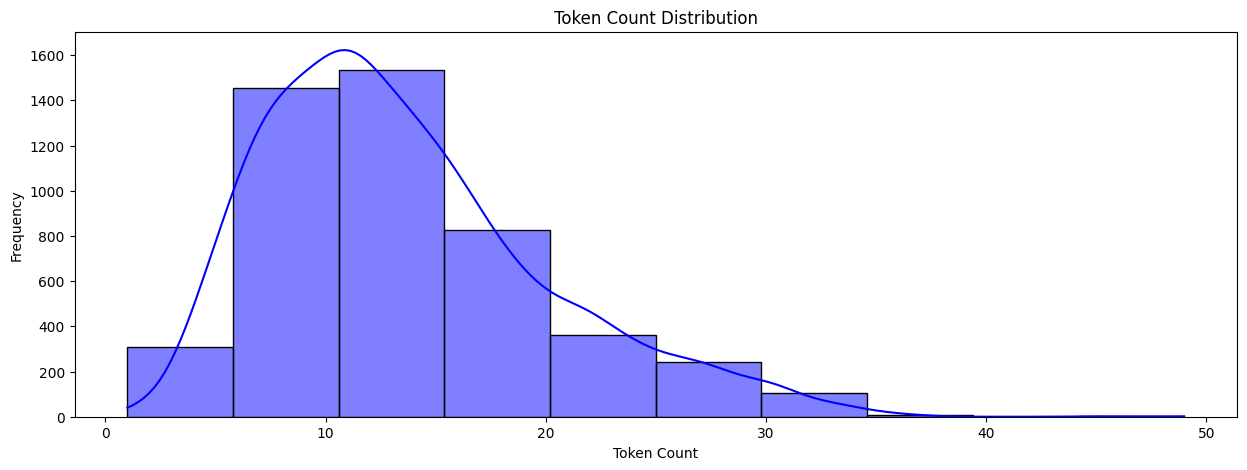

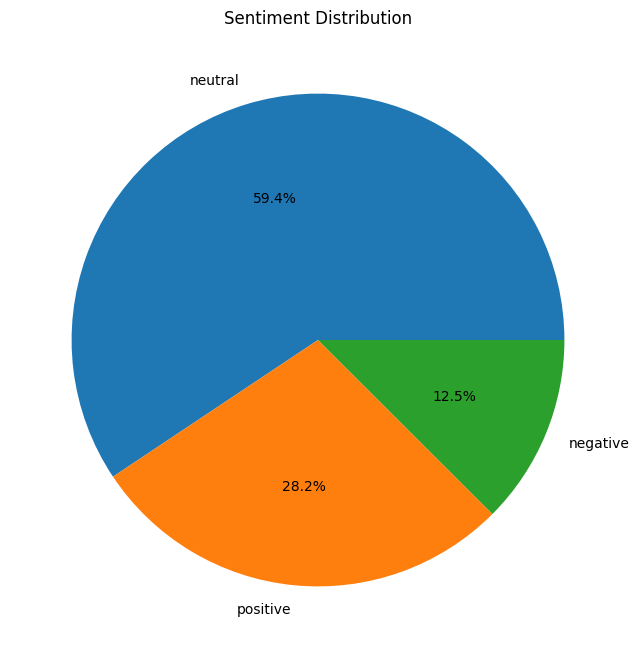

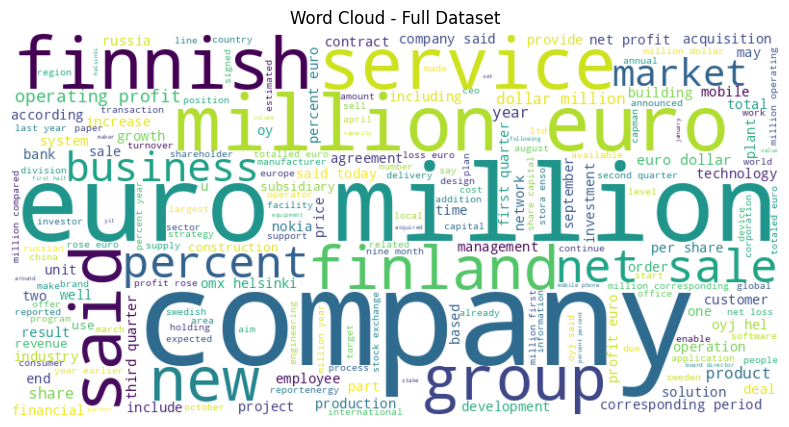

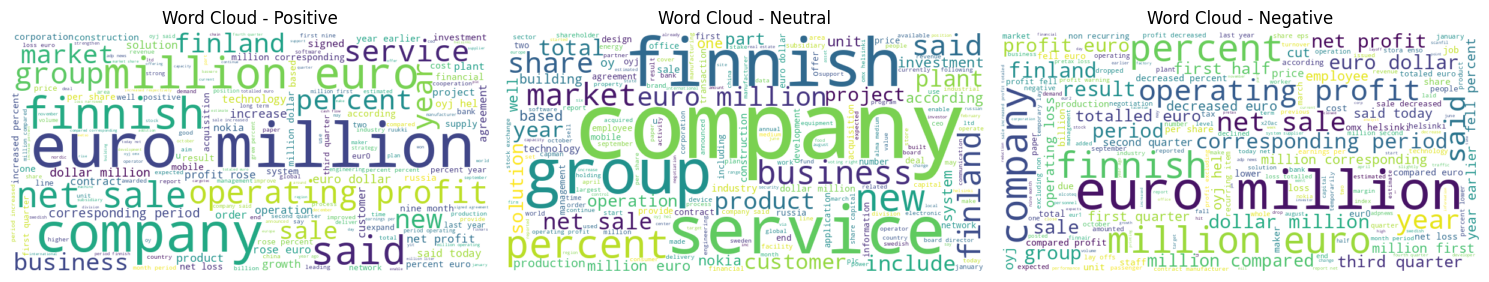

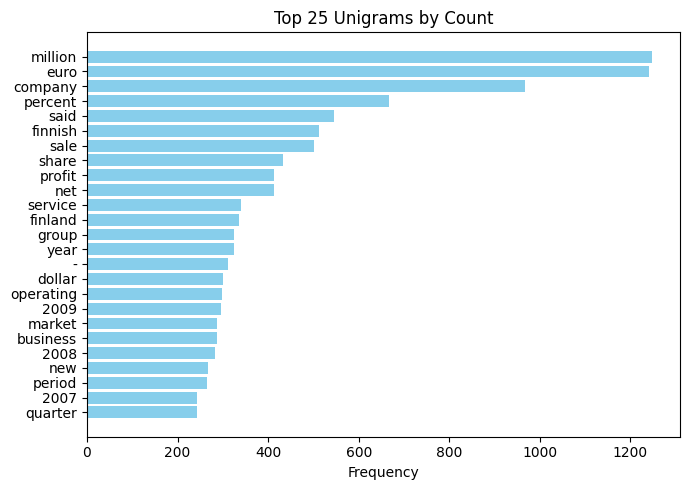

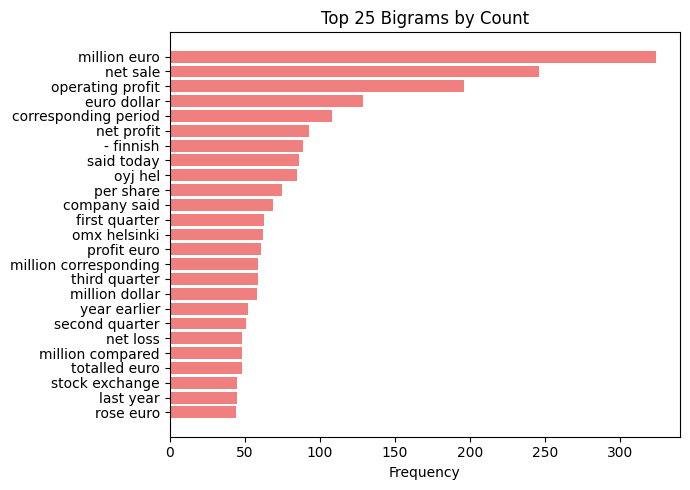

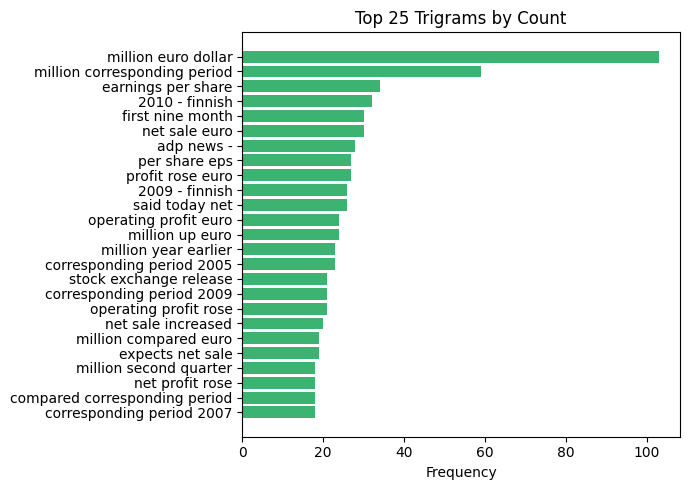

In [109]:
print("\n=== DATA VISUALIZATION ON PROCESSED DATASET  ===")
processed_df = data_preprocessing(df)
visualize_text_analysis(processed_df)

In [42]:
# # Process with only specific steps
# processed_df = data_preprocessing(
#     df,
#     remove_special_chars = True,
#     remove_punctuation = False,
#     lowercase = False,
#     convert_symbols = False,
#     normalize_spaces = False,
#     remove_stopwords = False,
#     expand_terms = False,
#     remove_urls = False,
#     lemmatize = False
# )
# processed_df.head()

,sentence,label,sentiment,token_count
0,"According to Gran , the company has no plans t...",1,neutral,25
1,Technopolis plans to develop in stages an area...,1,neutral,31
2,The international electronic industry company ...,0,negative,36
3,With the new production plant the company woul...,2,positive,33
4,According to the company s updated strategy f...,2,positive,41


In [14]:
print("\n=== SPLITTING DATA for MODELS ===")
train_df_finbert, val_df_finbert, test_df_finbert = stratified_split_data(df)
train_df_film, val_df_film, test_df_film = stratified_split_data(df)
train_df_qwen, val_df_qwen, test_df_qwen = stratified_split_data(df)



=== SPLITTING DATA for MODELS ===
Train: 3,387 samples (70%)
Validation: 726 samples (15%)
Test: 727 samples (15%)
Train: 3,387 samples (70%)
Validation: 726 samples (15%)
Test: 727 samples (15%)
Train: 3,387 samples (70%)
Validation: 726 samples (15%)
Test: 727 samples (15%)


# MODELS & *RESULTS*

In [15]:
print("\n=== INITIALIZING WANDB ===")
wandb_login()


=== INITIALIZING WANDB ===


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: onrtncy (onrtncy-university-of-gloucestershire) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Successfully logged into Weights & Biases


# FINBERT

In [93]:
# Load FinBERT model and tokenizer for financial sentiment analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize tokenizer for FinBERT model
tokenizer_finbert = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# Load FinBERT model for sentiment classification (3 labels: positive, negative, neutral)
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)

# Detect available computing device (CPU/GPU)
device_finbert = get_device()  # Ensure compatibility with GPU if available

# Move model to selected device for optimized computation
model_finbert.to(device_finbert)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [94]:
#  Tokenization function
def tokenize_function_finbert(example):
    return tokenizer_finbert(example["sentence"], padding="max_length", truncation=True, max_length=512)

# pandas dataframe → Huggingface Dataset
train_dataset_finbert = Dataset.from_pandas(train_df_finbert)
val_dataset_finbert   = Dataset.from_pandas(val_df_finbert)
test_dataset_finbert  = Dataset.from_pandas(test_df_finbert)

# Tokenization
train_dataset_finbert = train_dataset_finbert.map(tokenize_function_finbert, batched=True)
val_dataset_finbert   = val_dataset_finbert.map(tokenize_function_finbert, batched=True)
test_dataset_finbert  = test_dataset_finbert.map(tokenize_function_finbert, batched=True)

#  Target column rename
train_dataset_finbert = train_dataset_finbert.rename_column("label", "labels")
val_dataset_finbert   = val_dataset_finbert.rename_column("label", "labels")
test_dataset_finbert  = test_dataset_finbert.rename_column("label", "labels")

# Tokenization function for FinBERT model
def tokenize_function_finbert(example):
    """
    Tokenizes the 'sentence' field using the FinBERT tokenizer.
    Applies padding and truncation to ensure uniform input length.
    """
    return tokenizer_finbert(example["sentence"], padding="max_length", truncation=True, max_length=512)

# Convert Pandas DataFrame into Hugging Face Dataset format
train_dataset_finbert = Dataset.from_pandas(train_df_finbert)  # Training dataset
val_dataset_finbert   = Dataset.from_pandas(val_df_finbert)    # Validation dataset
test_dataset_finbert  = Dataset.from_pandas(test_df_finbert)   # Test dataset

# Apply tokenization to datasets
train_dataset_finbert = train_dataset_finbert.map(tokenize_function_finbert, batched=True)
val_dataset_finbert   = val_dataset_finbert.map(tokenize_function_finbert, batched=True)
test_dataset_finbert  = test_dataset_finbert.map(tokenize_function_finbert, batched=True)

# Rename target column 'label' to 'labels' (required for Hugging Face models)
train_dataset_finbert = train_dataset_finbert.rename_column("label", "labels")
val_dataset_finbert   = val_dataset_finbert.rename_column("label", "labels")
test_dataset_finbert  = test_dataset_finbert.rename_column("label", "labels")

Map:   0%|          | 0/3387 [00:00<?, ? examples/s]

Map:   0%|          | 0/726 [00:00<?, ? examples/s]

Map:   0%|          | 0/727 [00:00<?, ? examples/s]

Map:   0%|          | 0/3387 [00:00<?, ? examples/s]

Map:   0%|          | 0/726 [00:00<?, ? examples/s]

Map:   0%|          | 0/727 [00:00<?, ? examples/s]

In [95]:
# Drop empty columns and set the dataset format for PyTorch tensors
# Convert datasets into PyTorch format, keeping only relevant columns
train_dataset_finbert.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset_finbert.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset_finbert.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [96]:
# Evaluation metrics for FinBERT sentiment analysis
def compute_metrics_finbert(p):
    """
    Computes evaluation metrics for FinBERT model predictions.

    Parameters:
    p (EvalPrediction): Hugging Face's evaluation predictions object.

    Returns:
    dict: Dictionary containing accuracy, precision, recall, and F1-score.
    """
    preds = torch.argmax(torch.tensor(p.predictions), dim=1)  # Convert logits to class predictions
    labels = torch.tensor(p.label_ids)  # Extract true labels

    acc = accuracy_score(labels, preds)  # Calculate accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")  # Precision, recall, F1

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Confusion Matrix Visualization & Classification Metrics
def plot_confusion_matrix_and_metrics(predictions, true_labels, model_name):
    """
    Plots the confusion matrix and prints classification metrics for FinBERT sentiment analysis.

    Parameters:
    predictions (np.ndarray): Model output logits or class probabilities.
    true_labels (np.ndarray): Ground truth labels.
    model_name (str): Name of the model for display purposes.
    """

    # Convert logits into class predictions
    preds = np.argmax(predictions, axis=1)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Print classification report with precision, recall, F1-score, and accuracy
    print(f"\nClassification Report - {model_name}:\n")
    print(classification_report(true_labels, preds, target_names=["negative", "neutral", "positive"]))

# Define training parameters for FinBERT fine-tuning
training_args_finbert = TrainingArguments(
    # Output configuration
    output_dir="./results_finbert",          # Output directory for model checkpoints and logs
    run_name="finbert_run",                 # WandB/Tensorboard run identifier

    # Training/evaluation modes
    do_train=True,                          # Enable training
    do_eval=True,                           # Enable evaluation during training
    evaluation_strategy="epoch",             # Evaluate after each epoch
    save_strategy="epoch",                  # Save model after each epoch

    # Batch configuration
    per_device_train_batch_size=8,          # Batch size per GPU for training
    per_device_eval_batch_size=8,           # Batch size per GPU for evaluation

    # Training schedule
    num_train_epochs=5,                     # Total number of training epochs
    learning_rate=1e-5,                     # Initial learning rate (Adam optimizer)
    weight_decay=0.01,                      # L2 regularization strength
    warmup_ratio=0.1,                       #% Percentage of training steps for warmup
    lr_scheduler_type="linear",             # Learning rate scheduler type

    # Checkpointing
    save_steps=100,                         # Save checkpoint every N steps
    save_total_limit=1,                     # Maximum number of checkpoints to keep
    load_best_model_at_end=True,            # Load the best model at training end

    # Evaluation
    eval_steps=100,                         # Evaluate every N steps
    metric_for_best_model="f1",             # Metric to determine best model
    greater_is_better=True,                 # Higher F1 is better

    # Logging
    logging_steps=100,                      # Log metrics every N steps

    # Reproducibility
    seed=42                                 # Random seed for initialization
)

In [97]:
# Initialize the Trainer for FinBERT fine-tuning
trainer_finbert = Trainer(
    model=model_finbert,  # Load the pre-trained FinBERT model
    args=training_args_finbert,  # Set training parameters
    train_dataset=train_dataset_finbert,  # Provide training dataset
    eval_dataset=val_dataset_finbert,  # Provide validation dataset
    compute_metrics=compute_metrics_finbert  # Attach function to evaluate model performance
)

# Fine-tune the FinBERT model using training data
trainer_finbert.train()

# Make predictions on the test set and compute evaluation metrics
predictions_finbert = trainer_finbert.predict(test_dataset_finbert)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.404200,0.392328,0.853994,0.852369,0.798140,0.821357
2,0.324100,0.421458,0.866391,0.846961,0.866272,0.856071
3,0.133100,0.498357,0.873278,0.855110,0.872658,0.862876
4,0.085000,0.540918,0.877410,0.862707,0.868954,0.865743
5,0.053500,0.566492,0.873278,0.858141,0.864359,0.861075


{'test_loss': 0.5063385367393494, 'test_accuracy': 0.8762035763411279, 'test_precision': 0.853241995051286, 'test_recall': 0.8773110508882866, 'test_f1': 0.8643136514667661, 'test_runtime': 1.635, 'test_samples_per_second': 444.653, 'test_steps_per_second': 55.658}


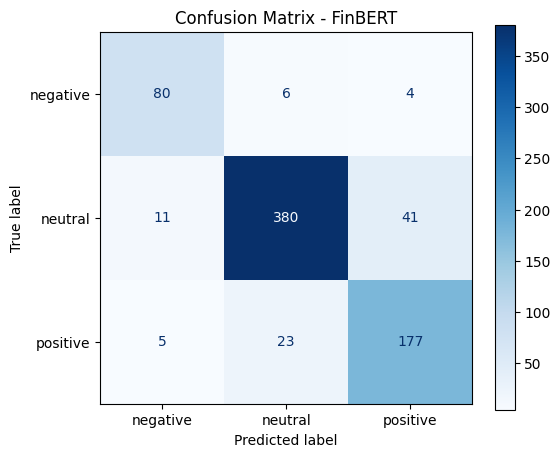


Classification Report - FinBERT:

              precision    recall  f1-score   support

    negative       0.83      0.89      0.86        90
     neutral       0.93      0.88      0.90       432
    positive       0.80      0.86      0.83       205

    accuracy                           0.88       727
   macro avg       0.85      0.88      0.86       727
weighted avg       0.88      0.88      0.88       727



In [98]:
print(predictions_finbert.metrics)
plot_confusion_matrix_and_metrics(predictions_finbert.predictions, predictions_finbert.label_ids, "FinBERT")

# FINANCIAL LANGUAGE MODEL (FiLM)

In [99]:
# Initialize tokenizer and model for FiLM (Financial Language Model)
tokenizer_film = AutoTokenizer.from_pretrained("roberta-base")  # Load RoBERTa-based tokenizer
model_film     = AutoModelForSequenceClassification.from_pretrained("HYdsl/FiLM", num_labels=3)  # Load FiLM model with 3 sentiment labels

# Detect available computing device (CPU/GPU)
device_film = get_device()  # Ensure compatibility with GPU if available

# Move model to selected device for optimized inference and training
model_film.to(device_film)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HYdsl/FiLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [100]:
# Convert Pandas DataFrame to Hugging Face Dataset format
train_dataset_film = Dataset.from_pandas(train_df_film)  # Training dataset
val_dataset_film   = Dataset.from_pandas(val_df_film)    # Validation dataset
test_dataset_film  = Dataset.from_pandas(test_df_film)   # Test dataset

In [101]:
# Tokenization function for FiLM (Financial Language Model)
def tokenize_function_film(example):
    """
    Tokenizes the 'sentence' field using the FiLM tokenizer.
    Applies padding and truncation to ensure uniform input length.
    """
    return tokenizer_film(example["sentence"], padding="max_length", truncation=True, max_length=512)

# Convert datasets into tokenized format
train_dataset_film = train_dataset_film.map(tokenize_function_film, batched=True)  # Tokenize training data
val_dataset_film   = val_dataset_film.map(tokenize_function_film, batched=True)  # Tokenize validation data
test_dataset_film  = test_dataset_film.map(tokenize_function_film, batched=True)  # Tokenize test data

# Adjust target column name to 'labels' for Hugging Face compatibility
train_dataset_film = train_dataset_film.rename_column("label", "labels")
val_dataset_film   = val_dataset_film.rename_column("label", "labels")
test_dataset_film  = test_dataset_film.rename_column("label", "labels")

# Remove empty columns and set dataset format for PyTorch tensors
# Convert datasets into PyTorch format, keeping only relevant columns
train_dataset_film.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset_film.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset_film.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/3387 [00:00<?, ? examples/s]

Map:   0%|          | 0/726 [00:00<?, ? examples/s]

Map:   0%|          | 0/727 [00:00<?, ? examples/s]

In [102]:
# Evaluation metrics for FiLM sentiment classification
def compute_metrics_film(p):
    """
    Computes key evaluation metrics for the FiLM model predictions.

    Parameters:
    p (EvalPrediction): Hugging Face's evaluation predictions object.

    Returns:
    dict: Dictionary containing accuracy, precision, recall, and F1-score.
    """

    # Convert model logits into class predictions
    preds = torch.argmax(torch.tensor(p.predictions), dim=1)

    # Extract true labels
    labels = torch.tensor(p.label_ids)

    # Calculate accuracy
    acc = accuracy_score(labels, preds)

    # Compute precision, recall, and F1-score using macro averaging
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [103]:
# Configure training parameters for FiLM model fine-tuning
training_args_film = TrainingArguments(
    # Output configuration
    output_dir="./results_film",            # Directory for saving model checkpoints and logs
    run_name="film_run",                   # Experiment identifier for tracking systems (WandB/TensorBoard)

    # Training control flags
    do_train=True,                         # Enable model training
    do_eval=True,                          # Enable periodic evaluation

    # Evaluation strategy
    evaluation_strategy="epoch",           # Evaluate model after each training epoch
    save_strategy="epoch",                # Save model checkpoints after each epoch
    eval_steps=100,                       # Number of update steps between evaluations
    save_steps=100,                       # Number of steps between checkpoint saves

    # Batch configuration
    per_device_train_batch_size=8,        # Training batch size per accelerator device
    per_device_eval_batch_size=8,         # Evaluation batch size per accelerator device

    # Training regimen
    num_train_epochs=5,                   # Total number of training passes through dataset
    learning_rate=1e-5,                   # Initial learning rate for AdamW optimizer
    weight_decay=0.01,                    # Weight decay coefficient for regularization
    warmup_ratio=0.1,                     # Fraction of training steps for learning rate warmup
    lr_scheduler_type="linear",           # Learning rate scheduling strategy

    # Model selection
    metric_for_best_model="f1",           # Metric used to determine best model
    greater_is_better=True,               # Higher F1 scores indicate better performance
    load_best_model_at_end=True,          # Load best performing model at training completion

    # Resource management
    save_total_limit=1,                   # Maximum number of checkpoints to retain

    # Monitoring
    logging_steps=100,                    # Interval for logging training metrics

    # Reproducibility
    seed=42                               # Random seed for deterministic behavior
)

In [104]:
# Initialize Trainer for FiLM fine-tuning
trainer_film = Trainer(
    model=model_film,  # Load the pre-trained FiLM model
    args=training_args_film,  # Set training parameters
    train_dataset=train_dataset_film,  # Provide training dataset
    eval_dataset=val_dataset_film,  # Provide validation dataset
    compute_metrics=compute_metrics_film  # Attach function to evaluate model performance
)

# Fine-tune the FiLM model using training data
trainer_film.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.426300,0.345318,0.858127,0.854342,0.833722,0.841434
2,0.403400,0.439136,0.876033,0.862767,0.868243,0.865114
3,0.221000,0.579793,0.874656,0.855368,0.873802,0.863903
4,0.179700,0.586194,0.874656,0.856720,0.884129,0.868975
5,0.139200,0.611651,0.887052,0.870743,0.887094,0.878495


TrainOutput(global_step=2120, training_loss=0.30230306192951384, metrics={'train_runtime': 160.5739, 'train_samples_per_second': 105.465, 'train_steps_per_second': 13.203, 'total_flos': 4455825729223680.0, 'train_loss': 0.30230306192951384, 'epoch': 5.0})

{'test_loss': 0.7042593359947205, 'test_accuracy': 0.8775790921595599, 'test_precision': 0.8513750867360379, 'test_recall': 0.8905487804878048, 'test_f1': 0.8686408182932772, 'test_runtime': 1.727, 'test_samples_per_second': 420.964, 'test_steps_per_second': 52.693}


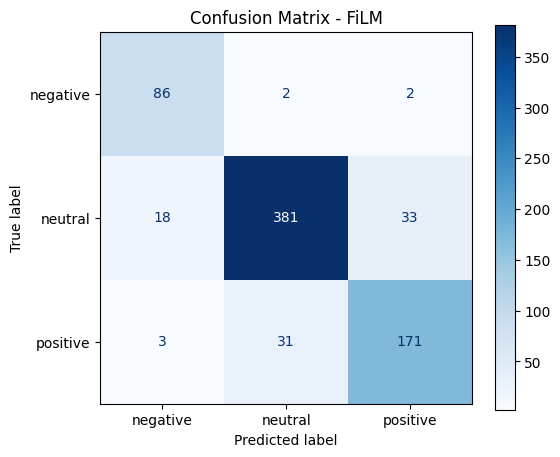


Classification Report - FiLM:

              precision    recall  f1-score   support

    negative       0.80      0.96      0.87        90
     neutral       0.92      0.88      0.90       432
    positive       0.83      0.83      0.83       205

    accuracy                           0.88       727
   macro avg       0.85      0.89      0.87       727
weighted avg       0.88      0.88      0.88       727



In [105]:
# Final Results: Predictions and Evaluation Metrics
# Perform predictions on the test set using the trained FiLM model
predictions_film = trainer_film.predict(test_dataset_film)

# Print evaluation metrics (accuracy, precision, recall, F1-score)
print(predictions_film.metrics)

# Plot confusion matrix and display classification performance
plot_confusion_matrix_and_metrics(predictions_film.predictions, predictions_film.label_ids, "FiLM")

# GWEN 2.5

In [16]:
# Qwen model
qwen_model_name = "Qwen/Qwen2.5-0.5B"  # Define the pre-trained Qwen model identifier

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(qwen_model_name, trust_remote_code=True)  # Load tokenizer for Qwen model
tokenizer.pad_token = tokenizer.eos_token  # Required for GPT-style models to ensure proper padding

# Load pre-trained Qwen model for causal language modeling
model = AutoModelForCausalLM.from_pretrained(
    qwen_model_name,  # Use defined model name
    torch_dtype=torch.float32,  # Set computation precision for better efficiency
    device_map="auto",  # Automatically allocate model to available hardware (CPU/GPU)
    trust_remote_code=True  # Allow execution of model-specific code for compatibility
)


torch.cuda.empty_cache() # PyTorch cache cleaning
torch.cuda.ipc_collect() # CUDA IPC memory cleanup

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
# # LoRA Configuration for Parameter-Efficient Fine-Tuning
# lora_config = LoraConfig(
#     r=8,  # Rank for low-rank adaptation
#     lora_alpha=16,  # Scaling factor for LoRA weights
#     target_modules=["q_proj", "v_proj"],  # Layers where LoRA is applied (query & value projections)
#     lora_dropout=0.1,  # Dropout rate to improve generalization
#     bias="none",  # No bias terms in LoRA layers
#     task_type="CAUSAL_LM"  # Model type set to causal language modeling
# )
# LoRA Configuration for Parameter-Efficient Fine-Tuning
lora_config = LoraConfig(
    r=4,  # Rank for low-rank adaptation
    lora_alpha=8,  # Scaling factor for LoRA weights
    target_modules=["q_proj"],  # Layers where LoRA is applied (query projection)
    lora_dropout=0.05,  # Dropout rate to improve generalization
    bias="none",  # No bias terms in LoRA layers
    task_type="CAUSAL_LM"  # Model type set to causal language modeling
)

# Apply LoRA configuration to the pre-trained model
model = get_peft_model(model, lora_config)

#  Enable training mode and gradient computation
model.train()  # Set model to training mode
model.enable_input_require_grads()  # Ensure gradients are required for input embeddings
model.gradient_checkpointing_enable()  # Activate gradient checkpointing for memory efficiency

# Verify which model parameters are trainable
model.print_trainable_parameters()

trainable params: 172,032 || all params: 494,204,800 || trainable%: 0.03480986020370502


In [86]:
# Label → Sentiment Mapping
label_map = {0: "negative", 1: "neutral", 2: "positive"}  # Map numerical labels to sentiment categories

# Function to format prompts for financial sentiment classification
def format_prompt(row):
    """
    Generates a text prompt for financial sentiment classification using various templates.

    Parameters:
    row (pd.Series): A row containing the financial sentence and its corresponding label.

    Returns:
    dict: A dictionary containing the formatted prompt and its assigned sentiment label.
    """
    random.seed(42)

    templates = [
        "What is the sentiment of this financial statement:\n\n{sentence}\n\nAnswer:",
        "Determine the tone of the following financial statement:\n\n{sentence}\n\nSentiment Classification:", #96
        "Sentiment evaluation:\n\n{sentence}\n\nClassification:",
        "Analyze whether the financial statement is positive, negative, or neutral:\n\n{sentence}\n\nAnswer:"
    ]

    template = random.choice(templates)  # Randomly select a template
    return {
        "text": template.format(sentence=row["sentence"]),  # Format sentence into prompt
        "label": label_map[row["label"]]  # Convert numerical label into sentiment category
    }

# Convert Pandas DataFrame to Hugging Face Dataset format
train_data = [format_prompt(row) for _, row in train_df_qwen.iterrows()]  # Process training data
val_data = [format_prompt(row) for _, row in val_df_qwen.iterrows()]  # Process validation data
test_data = [format_prompt(row) for _, row in test_df_qwen.iterrows()]  # Process test data

# Convert lists to Hugging Face Dataset format
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)

In [87]:
# Tokenization Function for QWEN
def tokenize(example):
    """
    Tokenizes input text and label for sentiment classification.

    Parameters:
    example (dict): Dictionary containing 'text' (financial statement) and 'label' (sentiment category).

    Returns:
    dict: Tokenized inputs including input IDs, attention mask, and labels.
    """

    # Combine text and label into a single input prompt
    full_text = example["text"] + " " + example["label"]

    # Apply tokenization with padding and truncation
    tokenized = tokenizer(
        full_text,  # Input sentence + sentiment label
        padding="max_length",  # Ensures all sequences have the same length
        truncation=True,  # Truncate long sequences if exceeding max_length
        max_length=128,  # Limit sequence length to 128 tokens
        return_tensors="pt"  # Convert output into PyTorch tensor format
    )

    # Extract tokenized values
    input_ids = tokenized["input_ids"][0]  # Encoded token IDs
    attention_mask = tokenized["attention_mask"][0]  # Attention mask (for handling padding)

    # Clone input IDs to use as labels for model training
    labels = input_ids.clone()

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

# Apply Tokenization to Datasets
train_dataset = train_dataset.map(tokenize)  # Process training dataset
val_dataset = val_dataset.map(tokenize)  # Process validation dataset
test_dataset = test_dataset.map(tokenize)  # Process test dataset

# Convert datasets into PyTorch tensor format for model training
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/3387 [00:00<?, ? examples/s]

Map:   0%|          | 0/726 [00:00<?, ? examples/s]

Map:   0%|          | 0/727 [00:00<?, ? examples/s]

In [88]:
optimize_memory_usage()

training_args = TrainingArguments(
    output_dir="./results_qwen",  # Directory to save model checkpoints
    run_name="qwen_run",  # Experiment name for tracking
    per_device_train_batch_size=4,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=25,
    fp16=True,
    gradient_checkpointing=True,
    report_to="none",
    seed=42
)

# Initialize Trainer for Model Training
trainer = Trainer(
    model=model,  # Load the pre-trained Qwen model
    args=training_args,  # Apply defined training parameters
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=train_dataset,  # Validation dataset
    tokenizer=tokenizer # Tokenizer associated with the model

)
optimize_memory_usage()
# Fine-Tune the Model
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,0.771200,0.804645


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


TrainOutput(global_step=847, training_loss=0.8071782405992889, metrics={'train_runtime': 318.0724, 'train_samples_per_second': 10.649, 'train_steps_per_second': 2.663, 'total_flos': 931417787695104.0, 'train_loss': 0.8071782405992889, 'epoch': 1.0})

In [89]:
optimize_memory_usage()  # optimize memory
# Define batch size
batch_size = 4

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Set the model to evaluation mode (disables dropout & batch norm updates)
model.eval()

# Move model to GPU for faster inference
model = model.to("cuda")

# Store predictions
all_preds = []

# Perform inference with no gradient calculations (for efficiency)
with torch.no_grad():
    for batch in tqdm(test_loader):  # Iterate over test dataset
        input_ids = batch["input_ids"].to("cuda")  # Move tokenized inputs to GPU
        attention_mask = batch["attention_mask"].to("cuda")  # Move attention mask to GPU

        # Generate model predictions
        outputs = model.generate(
            input_ids=input_ids,  # Provide input token IDs
            attention_mask=attention_mask,  # Include attention mask for proper handling
            max_new_tokens=10,  # Limit generated sequence length
            pad_token_id=tokenizer.pad_token_id  # Ensure correct padding behavior
        )

        # Decode generated outputs into readable text
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Append predictions to list
        all_preds.extend(decoded)

100%|██████████| 182/182 [01:02<00:00,  2.89it/s]


              precision    recall  f1-score   support

    negative       0.75      1.00      0.86        90
     neutral       1.00      0.99      0.99       432
    positive       1.00      0.87      0.93       205

    accuracy                           0.96       727
   macro avg       0.92      0.95      0.93       727
weighted avg       0.97      0.96      0.96       727



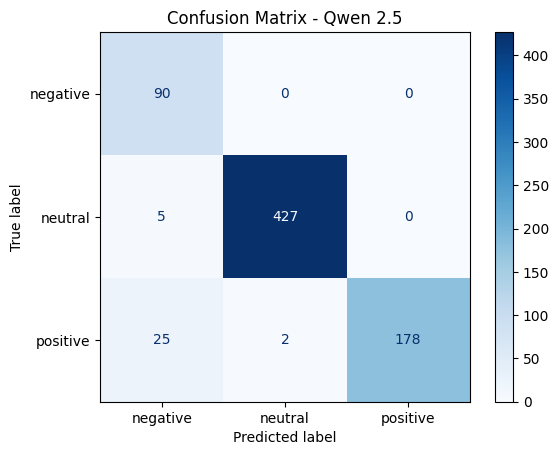

In [90]:
# Retrieve Actual Sentiment Labels from Test Data
actual_text_labels = test_df_qwen["sentiment"].tolist()  # Extract true sentiment labels

# Normalize Model Predictions
def normalize_label(pred):
    """
    Converts raw model predictions into standardized sentiment categories.

    Parameters:
    pred (str): Model-generated sentiment prediction.

    Returns:
    str: Normalized sentiment label ("negative", "neutral", "positive") or "unknown" if undefined.
    """
    for sentiment in ["negative", "neutral", "positive"]:
        if sentiment in pred.lower():  # Check if sentiment exists in prediction text
            return sentiment
    return "unknown"  # Return "unknown" if no valid sentiment is detected

# Apply normalization to all predictions
normalized_preds = [normalize_label(pred) for pred in all_preds]

# Filter Valid Predictions
filtered_true = []  # List to store actual labels for valid cases
filtered_pred = []  # List to store predicted labels for valid cases

for t, p in zip(actual_text_labels, normalized_preds):
    if p != "unknown":  # Ignore cases where prediction is undefined
        filtered_true.append(t)  # Append valid true label
        filtered_pred.append(p)  # Append valid predicted label

# Generate Confusion Matrix and Classification Metrics
labels = ["negative", "neutral", "positive"]  # Define sentiment classes

# Calculate Accuracy
accuracy_qwen = accuracy_score(filtered_true, filtered_pred)  # Compute overall accuracy

# Compute Precision, Recall, and F1-score using macro averaging
precision_qwen, recall_qwen, f1_qwen, _ = precision_recall_fscore_support(
    filtered_true, filtered_pred, labels=labels, average="macro"
)

# Print Classification Report
print(classification_report(filtered_true, filtered_pred, labels=labels))

# Compute Confusion Matrix
cm = confusion_matrix(filtered_true, filtered_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot Confusion Matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Qwen 2.5")
plt.show()

In [91]:
# Calculate accuracy score
accuracy = accuracy_score(filtered_true, filtered_pred)

# Compute precision, recall, and F1 score (macro average)
precision, recall, f1, _ = precision_recall_fscore_support(
    filtered_true, filtered_pred, labels=labels, average="macro"
)

# Collect all metrics in a dictionary
metrics = {
    "accuracy": round(accuracy, 2),        # Rounded to 2 decimal places
    "precision": round(precision, 2),     # Precision score (macro avg)
    "recall": round(recall, 2),           # Recall score (macro avg)
    "f1": round(f1, 2)                    # F1 score (macro avg)
}

# MODEL COMPARISON

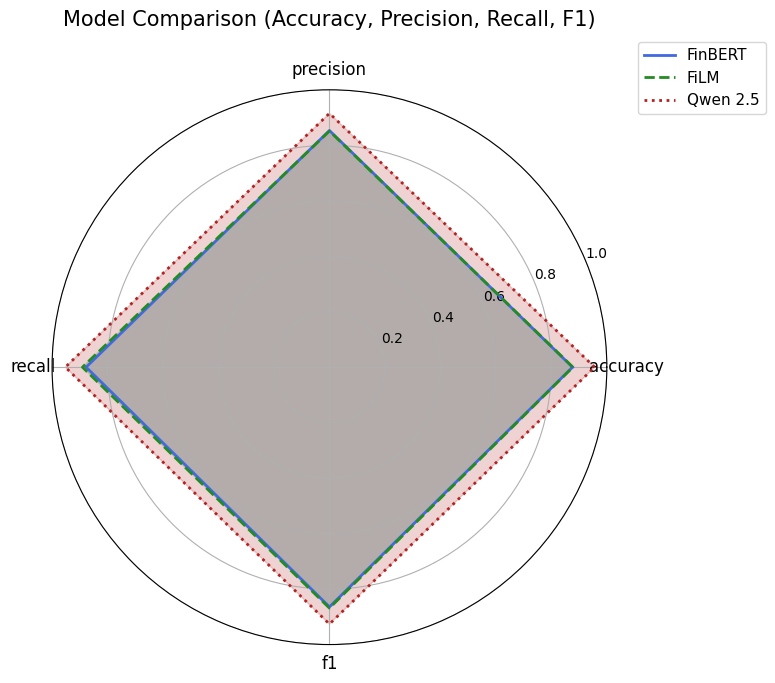

In [106]:
# model scores
finbert_scores = {
    "accuracy": round(predictions_finbert.metrics["test_accuracy"], 4),
    "precision": round(predictions_finbert.metrics["test_precision"], 4),
    "recall": round(predictions_finbert.metrics["test_recall"], 4),
    "f1": round(predictions_finbert.metrics["test_f1"], 4)
}

film_scores = {
    "accuracy": round(predictions_film.metrics["test_accuracy"], 4),
    "precision": round(predictions_film.metrics["test_precision"], 4),
    "recall": round(predictions_film.metrics["test_recall"], 4),
    "f1": round(predictions_film.metrics["test_f1"], 4)
}

qwen_scores = {
    "accuracy": round(accuracy_qwen, 4),
    "precision": round(precision_qwen, 4),
    "recall": round(recall_qwen, 4),
    "f1": round(f1_qwen, 4)
}


# Define metric labels and order
metrics = list(finbert_scores.keys())
num_metrics = len(metrics)

# Extract values for each model
finbert_values = list(finbert_scores.values())
film_values = list(film_scores.values())
qwen_values = list(qwen_scores.values())

# Close the radar chart loop by repeating the first value at the end
finbert_values += finbert_values[:1]
film_values += film_values[:1]
qwen_values += qwen_values[:1]

# Set the angle for each axis
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]

# Create radar chart figure
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot FinBERT - Solid blue line
ax.plot(angles, finbert_values, label="FinBERT", color="royalblue", linewidth=2, linestyle='-')
ax.fill(angles, finbert_values, color="royalblue", alpha=0.2)

# Plot FiLM - Dashed green line
ax.plot(angles, film_values, label="FiLM", color="forestgreen", linewidth=2, linestyle='--')
ax.fill(angles, film_values, color="forestgreen", alpha=0.2)

# Plot Qwen 2.5 - Dotted red line
ax.plot(angles, qwen_values, label="Qwen 2.5", color="firebrick", linewidth=2, linestyle=':')
ax.fill(angles, qwen_values, color="firebrick", alpha=0.2)

# Add metric labels around the chart
ax.set_thetagrids(np.degrees(angles[:-1]), metrics, fontsize=12)

# Set chart title and bounds
ax.set_title("Model Comparison (Accuracy, Precision, Recall, F1)", size=15, y=1.1)
ax.set_ylim(0, 1)

# Add legend outside the plot
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=11)

# Apply layout formatting
plt.tight_layout()
plt.show()

In [107]:
print("\nModel Evaluation Scores:")
print("FinBERT:", finbert_scores)
print("FiLM:   ", film_scores)
print("Qwen:   ", qwen_scores)


Model Evaluation Scores:
FinBERT: {'accuracy': 0.8762, 'precision': 0.8532, 'recall': 0.8773, 'f1': 0.8643}
FiLM:    {'accuracy': 0.8776, 'precision': 0.8514, 'recall': 0.8905, 'f1': 0.8686}
Qwen:    {'accuracy': 0.956, 'precision': 0.9151, 'recall': 0.9522, 'f1': 0.9262}
